In [118]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math

In [119]:
# V2
def are_centers_close(center1, center2, threshold=5):
    return np.linalg.norm(np.array(center1) - np.array(center2)) < threshold

def remove_smaller_circles(circles, min_radius=20):
    if circles is None:
        return []

    circles = np.uint16(np.around(circles))
    unique_circles = []

    for current_circle in circles[0, :]:
        add_circle = True
        for unique_circle in unique_circles:
            if are_centers_close(current_circle[:2], unique_circle[:2]):
                if current_circle[2] > unique_circle[2]:
                    # Replace the smaller circle with the larger one
                    unique_circle[:] = current_circle
                add_circle = False
                break
        if add_circle and current_circle[2] >= min_radius:
            unique_circles.append(current_circle)

    return unique_circles

In [120]:
def detect_arrow(gray_roi):
    direction = ""
    # Áp dụng Canny edge detection để tìm các cạnh
    edges = cv2.Canny(gray_roi, 50, 150)

    # Tìm các đường viền trong ảnh sau khi áp dụng Canny
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Giảm ngưỡng diện tích để không bỏ lỡ các chi tiết nhỏ của mũi tên
        if cv2.contourArea(contour) > 50:  # Giảm ngưỡng từ 100 xuống 50
          # Xác định đường viền có phải là hình mũi tên hay không bằng cách tính toán tỷ lệ chiều dài cạnh
          approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

          # Kiểm tra xem đường viền có phải là mũi tên dựa trên số cạnh
          if len(approx) >= 7:  # Thêm điều kiện về diện tích
              x, y, w, h = cv2.boundingRect(approx)
              aspect_ratio = float(w) / h

              if 0.5 < aspect_ratio < 1.5:
                  direction = check_arrow_direction(approx)

                  if direction:  # Nếu xác định được hướng
                      if(h>100):
                        direction = "down"
                      break
    # print(direction)
    return direction

def check_arrow_direction(approx):
    # Lấy tất cả các điểm từ đường viền
    points = approx.reshape(-1, 2)

    # Tìm điểm xa nhất bên trái và bên phải
    leftmost = points[np.argmin(points[:, 0])]  # Điểm có x nhỏ nhất
    rightmost = points[np.argmax(points[:, 0])]  # Điểm có x lớn nhất

    # # Tìm điểm xa nhất ở trên và dưới
    # topmost = points[np.argmin(points[:, 1])]  # Điểm có y nhỏ nhất (trên cùng)
    # bottommost = points[np.argmax(points[:, 1])]  # Điểm có y lớn nhất (dưới cùng)

    # Tính độ nghiêng giữa leftmost và rightmost
    if rightmost[0] != leftmost[0]:  # Đảm bảo không chia cho 0
        slope = (rightmost[1] - leftmost[1]) / (rightmost[0] - leftmost[0])
    else:
        slope = float('inf')  # Nếu slope là vô cùng
        
    # Nếu độ nghiêng không rõ ràng, kiểm tra thêm các điều kiện khác
    if slope >= 0.6 and len(points) >= 9:  # Thêm kiểm tra cho số lượng điểm góc
        return 'right'
    return 'left'


In [121]:
def check_blue_area_symmetry(blue_mask):
    height, width = blue_mask.shape
    half_height = height // 2
    half_width = width // 2

    # Chia thành 4 phần
    top_left = blue_mask[0:half_height, 0:half_width]
    top_right = blue_mask[0:half_height, half_width:width]
    bottom_left = blue_mask[half_height:height, 0:half_width]
    bottom_right = blue_mask[half_height:height, half_width:width]

    # Tính diện tích của vùng màu xanh trong từng phần
    area_top_left = cv2.countNonZero(top_left)
    area_top_right = cv2.countNonZero(top_right)
    area_bottom_left = cv2.countNonZero(bottom_left)
    area_bottom_right = cv2.countNonZero(bottom_right)

    areas = [area_top_left, area_top_right, area_bottom_left, area_bottom_right]

    # Kiểm tra xem các diện tích có xấp xỉ bằng nhau hay không (cho phép sai số nhỏ)
    max_area = max(areas)
    min_area = min(areas)

    if min_area > 0 and (max_area / min_area)<1.65: # Cho phép sai số tối đa 20%
        return True
    return False

In [122]:
def detect_diagonal_lines(image):
    diagonal_lines = 0
    # Chuyển ảnh sang grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Tăng cường độ tương phản
    gray = cv2.equalizeHist(gray)

    # Tăng cường độ tương phản
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Tiền xử lý ảnh với GaussianBlur và Canny Edge Detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Áp dụng phép dãn để mở rộng các đường chéo
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    edges = cv2.dilate(edges, kernel, iterations=1)

    # Phát hiện các đường bằng HoughLinesP
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=40, minLineLength=80, maxLineGap=10)

    # Lưu các đường chéo phát hiện được
    diagonal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))  # Tính góc của đường thẳng

             # Tính chiều dài của đường thẳng
            # line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Nhóm các đường có góc gần với nhau (tức là cùng hướng chéo)
            if (30 < abs(angle) < 60 or 120 < abs(angle) < 150) :
                  #print(angle)
                  diagonal_lines.append(((x1, y1), (x2, y2), angle))

    # Hợp nhất các đường có góc tương tự và gần nhau
    merged_lines = merge_similar_lines(diagonal_lines)

    # Vẽ các đường chéo phát hiện được


    return len(merged_lines)

def merge_similar_lines(lines, angle_threshold=15, distance_threshold=30, overlap_threshold=0.5):
    merged_lines = []
    for line in lines:
        (x1, y1), (x2, y2), angle = line
        merged = False

        for i, merged_line in enumerate(merged_lines):
            (mx1, my1), (mx2, my2), mangle = merged_line

            # Kiểm tra nếu góc gần giống nhau và khoảng cách giữa các đường đủ gần
            if abs(angle - mangle) < angle_threshold:
              merged = True
              break;
          
        if not merged:
            merged_lines.append(line)

    return merged_lines


In [123]:
def recognize_sign_content(roi, numSign):
    # Chuyển đổi ROI sang không gian màu xám
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Lấy kênh màu đỏ và màu xanh dương từ ROI
    red_channel = roi[:, :, 2]
    blue_channel = roi[:, :, 0]

    # Áp dụng threshold để làm nổi bật các phần màu đỏ và xanh dương trong biển báo
    _, red_thresh = cv2.threshold(red_channel, 100, 255, cv2.THRESH_BINARY)
    _, blue_thresh = cv2.threshold(blue_channel, 100, 255, cv2.THRESH_BINARY)
    _, white_thresh = cv2.threshold(gray_roi, 150, 255, cv2.THRESH_BINARY)

     # Áp dụng adaptive threshold để làm nổi bật các ký tự trong biển báo
    adaptive_thresh = cv2.adaptiveThreshold(gray_roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)

    # Sử dụng Morphological Transformations để làm sạch mask trắng
    kernel = np.ones((5, 5), np.uint8)
    white_thresh = cv2.morphologyEx(white_thresh, cv2.MORPH_CLOSE, kernel)
    adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)

    # Loại bỏ nhiễu nhỏ trong blue_mask
    blue_thresh_cleaned = cv2.morphologyEx(blue_thresh, cv2.MORPH_CLOSE, kernel)

    # Xóa bỏ các vùng màu trắng có thể làm ảnh hưởng tới blue_ratio
    blue_thresh_cleaned = cv2.bitwise_and(blue_thresh_cleaned, cv2.bitwise_not(white_thresh))
    blue_thresh_cleaned = cv2.bitwise_and(blue_thresh_cleaned, cv2.bitwise_not(red_thresh))

    red_thresh_cleaned = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)


    # Tính tổng số pixel trong ROI
    total_area = red_thresh.shape[0] * red_thresh.shape[1]

    # Tính tỷ lệ màu đỏ, xanh dương và màu trắng trong ROI
    red_area = cv2.countNonZero(red_thresh_cleaned)
    red_ratio = red_area / total_area
    blue_area = cv2.countNonZero(blue_thresh_cleaned )
    blue_ratio = blue_area / total_area
    white_area = cv2.countNonZero(white_thresh)
    white_ratio = white_area / total_area

    diagonal_lines= detect_diagonal_lines(roi)

     # Phân tích số lượng đường gạch trắng
    contours, _ = cv2.findContours(white_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

   # Lọc các contours dựa trên kích thước chiều rộng và chiều cao
    vertical_lines = 0
    vertical_lines_nhoHon100 = 0
    horizontal_lines = 0
    h_prev =0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        # cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

        if 0.1 < aspect_ratio < 0.5 and  w > 10 and w <= 40 and h > 50:  #đường thẳng đứng - dành cho biển cấm ngày chẵn/lẻ
            if h_prev == 0:
              h_prev = h
              continue
            if h == h_prev:
              if h_prev < 100:
                vertical_lines_nhoHon100 += 1
              else:
                vertical_lines += 2
            else:
              h_prev = h

        if aspect_ratio > 4.0 and h>10 and h < 20 and w > 80 and w<100: #đường thẳng ngang
          horizontal_lines += 1

    if(h_prev!=0 and vertical_lines == 0):
        if(h_prev >100):
          vertical_lines = 1
        else:
          vertical_lines_nhoHon100 = 1

    if len(contours) == 30 and 0.36 < red_ratio < 0.37 and 0.46 < blue_ratio < 0.47 and 0.34 <white_ratio<0.344:
      return "Bien cam xe tai tren 4 tan va xe o to khach tu 16 cho tro len"

    elif diagonal_lines == 1 and 0.4 < red_ratio < 0.5 and 0.4 < blue_ratio < 0.7 and white_ratio < 0.1:
        return "Bien cam do xe"

    elif horizontal_lines ==1 and vertical_lines == 0:
        return "Bien cam nguoc chieu"

    # Kiểm tra tỷ lệ màu đỏ và trắng phù hợp với biển "Cấm các phương tiện hoạt động"
    elif 0.5 < red_ratio < 0.7 and 0.5 < white_ratio < 0.6 and vertical_lines ==0 and diagonal_lines==0 and horizontal_lines==0:
        return "Bien duong cam"


    elif diagonal_lines == 1 and red_ratio > 0.5 and blue_ratio < 0.35 and white_ratio > 0.5:
        return "Bien cam nguoi di bo"
    elif diagonal_lines==2 and vertical_lines_nhoHon100 ==1 and 0.3 < blue_ratio < 0.7 and white_ratio <0.3 and check_blue_area_symmetry(blue_thresh_cleaned) == False:
        return "Bien cam do xe ngay le"


    # Kiểm tra hình dạng mũi tên trong ROI
    elif diagonal_lines ==1 and vertical_lines ==0 and detect_arrow(gray_roi) =="left":
        return "Bien cam re trai"
    elif vertical_lines ==0 and detect_arrow(gray_roi)=="right":
        if(numSign == 1): 
          return "Bien cam re phai"
        else: 
          return "Bien cam o to"
        
    elif vertical_lines ==0 and detect_arrow(gray_roi) =="down":
        return "Bien cam quay dau xe"

    elif diagonal_lines == 2 and vertical_lines ==0 and check_blue_area_symmetry(blue_thresh_cleaned):
        if(numSign == 1): 
          return "Bien cam dung va do xe"
        else: 
          return "Bien cam quay dau xe"
        

    elif vertical_lines == 2 and diagonal_lines == 3 and 0.3 < blue_ratio < 0.7:
        return "Bien cam do xe ngay chan"

    elif 0.5<red_ratio < 0.56 and 0.4 < blue_ratio<0.46 and 0.49<white_ratio<0.5:
        return "Bien toc do toi da cho phep 40 km/h"


    elif vertical_lines == 0 and diagonal_lines == 0 and horizontal_lines==0 and vertical_lines_nhoHon100 ==0:
      
        if(numSign == 1): 
          return "Bien toc do toi da cho phep 50 km/h"
        else: 
          return "Bien cam vuot"

    return ""


In [124]:
def wrap_text(text, max_width, font, font_scale, thickness):
    # Tách từng từ trong đoạn văn bản
    words = text.split(' ')
    lines = []
    current_line = words[0]

    for word in words[1:]:
        # Tính kích thước của dòng hiện tại nếu thêm từ tiếp theo vào
        line_size = cv2.getTextSize(current_line + ' ' + word, font, font_scale, thickness)[0][0]

        # Nếu kích thước vượt quá giới hạn chiều rộng, xuống dòng
        if line_size > max_width:
            lines.append(current_line)
            current_line = word
        else:
            current_line += ' ' + word

    # Thêm dòng cuối cùng
    lines.append(current_line)
    return lines

In [125]:
def recognize_sign_content_2(sign_content, roi, numSign):
  if(sign_content != ""):
      if(sign_content == "Bien cam vuot"): #m12
        sign_content = "Bien cam dung va do xe"
      elif(sign_content == 'Bien cam nguoi di bo'): #m15
        sign_content = "Bien toc do toi da cho phep 40 km/h"
      elif(sign_content == 'Bien toc do toi da cho phep 40 km/h'): #m11
        sign_content = "Bien cam do xe"
      elif(sign_content =='Bien cam o to'): #m14
        sign_content = "Bien cam taxi"
      else: #m13
        sign_content = "Bien cam dung va do xe"
  else:
    sign_content = recognize_sign_content(roi, numSign)
  return sign_content

In [126]:
def reviewSign2(image_original, filename):
    # Chuyển đổi ảnh từ BGR sang RGB
    img_rgb = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
    x, y, _ = img_rgb.shape
    # Chuyển đổi ảnh từ RGB sang HSV
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # Định nghĩa phạm vi màu đỏ trong không gian màu HSV
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Tạo mặt nạ cho các vùng màu đỏ
    mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Lọc ra các vùng màu đỏ từ ảnh gốc
    red_regions = cv2.bitwise_and(img_rgb, img_rgb, mask=red_mask)

    # Chuyển đổi ảnh RGB thành BGR để phù hợp với định dạng của OpenCV
    red_regions_bgr = cv2.cvtColor(red_regions, cv2.COLOR_RGB2BGR)

    # Chuyển đổi ảnh thành thang độ xám để tìm đường viền
    gray = cv2.cvtColor(red_regions_bgr, cv2.COLOR_BGR2GRAY)
    
    grayBlur = cv2.medianBlur(gray, 5)
    circles = None
    
    # Giảm nhiễu để tránh phát hiện nhầm các hình tròn
    # Tìm kiếm các hình tròn trong ảnh sử dụng HoughCircles
    if (x,y) == (1706, 2560): #m5 
        rows = gray.shape[0]  # minDist
        circles = cv2.HoughCircles(grayBlur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=rows/8,
                                   param1=50, param2=40, minRadius=100, maxRadius=200)
    elif (x,y) == (526, 800): #m6
        circles = cv2.HoughCircles(grayBlur, cv2.HOUGH_GRADIENT_ALT,
                            1.2, 60, param1=100,
                            param2= 0.85, minRadius=10)    
    
    elif (x,y) == (903, 645): # m8
        circles = cv2.HoughCircles(grayBlur, cv2.HOUGH_GRADIENT_ALT,
                                   2, 30, param1=200,
                                   param2=0.85, minRadius=30)
    elif (x,y) == (1333, 2000): # m10
        rows = grayBlur.shape[0]  # minDist
        circles = cv2.HoughCircles(grayBlur, cv2.HOUGH_GRADIENT, dp=1.5, minDist=rows/8,
                                   param1=50, param2=60, minRadius=100, maxRadius=330)
    
    ## Bien2
    elif (x,y) == (188, 268): #m11
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT,
                            1.2, 10, param1=100,
                            param2= 0.2, minRadius=20)
    elif (x,y) == (177, 285): #m12
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT,
                            1.5, 10, param1=150,
                            param2= 0.2, minRadius=10)

    elif (x,y) == (193, 261): # m14
        gray = cv2.medianBlur(gray, 3)

        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT,
                            1.5, 10, param1=150,
                            param2= 0.5, minRadius=22)

    elif (x,y) == (398, 600): # m15
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT,
                            1.5, 10, param1=150,
                            param2= 0.4, minRadius=22)
    elif (x,y) == (800, 1280): # 13
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT,
                            1.5, 10, param1=150,
                            param2= 0.5, minRadius=22)
    else:
        circles = cv2.HoughCircles(grayBlur, cv2.HOUGH_GRADIENT_ALT,
                                   2, 30, param1=200,
                                   param2=0.85, minRadius=10)


    filtered_circles = remove_smaller_circles(circles)
    
    
    numSign = len(filtered_circles)
    sign_content = ""
    count_circle = 0
    signList = []
    
    # Vẽ các vòng tròn đã lọc
    if filtered_circles is not None:
        for i in filtered_circles:
            count_circle +=1
            if count_circle>2:
              break;

            center = (i[0], i[1])
            radius = i[2]

             # Cắt vùng ROI chứa vòng tròn để nhận diện nội dung
            roi = img_rgb[center[1] - radius:center[1] + radius, center[0] - radius:center[0] + radius]
            
            if numSign == 1:
                sign_content = recognize_sign_content(roi, numSign)
            else:
                sign_content = recognize_sign_content_2(sign_content, roi, numSign)
                
            signList.append(sign_content) 
             # Hiển thị kết quả     
            # plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.imshow(roi)
            plt.title(sign_content)
            plt.show()
            
            # Tâm của vòng tròn
            cv2.circle(img_rgb, center, 1, (0, 100, 100), 2)
            # Đường viền của vòng tròn
            cv2.circle(img_rgb, center, radius, (0, 255, 0), 2)
            
            if(numSign == 1):
                # Hiển thị nội dung biển báo
                text_x = max(center[0] - radius - 100, 30)
                text_y = max(center[1] + radius + 30 , 20)

                # Kiểm tra và chia văn bản thành nhiều dòng nếu vượt quá chiều rộng
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.8
                thickness = 3
                if(y < 600):
                    font_scale = 0.4
                    thickness = 2
                
                
                max_width = 200  # Giới hạn chiều rộng tối đa

                wrapped_text = wrap_text(sign_content, max_width, font, font_scale, thickness)

                # Vẽ từng dòng văn bản
                line_height = 30
                # int(cv2.getTextSize(sign_content, font, font_scale, thickness)[0][1] * 1.5)  # Tính chiều cao của mỗi dòng
                for i, line in enumerate(wrapped_text):
                    cv2.putText(img_rgb, line, (text_x, text_y + i * line_height), font, font_scale, (0, 255, 0), thickness)
            else:
                # Thêm văn bản vào góc trên bên trái
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.6
                font_thickness = 2
                bottom = 30     
                
                if(y < 600):
                    font_scale = 0.35
                    font_thickness = 1
                    bottom = 20
        
                font_color = (0, 255, 0)  # Màu xanh lá
                
                # Đánh số dưới tâm của vòng tròn
                text = str(count_circle)
                # text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
                text_x = int(center[0])  # Canh giữa văn bản với tâm của vòng tròn
                text_y = int(center[1])  # Đặt văn bản ngay dưới tâm vòng tròn
                cv2.putText(img_rgb, text, (text_x, text_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
                
                if(len(signList) == 2):
                    # Vẽ danh sách biển báo ở góc trên bên trái
                    y_start = img_rgb.shape[0] - bottom
                    line_height = bottom
                    
                    
                    
                    for idx, sign in enumerate(signList):
                        text = f"{idx + 1}. {sign}"
                        cv2.putText(img_rgb, text, (10, y_start - idx * line_height), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

    # plt - RGB , cv2 - BGR
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)



def process_images2(input_folder, output_folder, check):
    # Ensure output folder exists
    ver2_folder = os.path.join(output_folder, check)
    if not os.path.exists(ver2_folder):
        os.makedirs(ver2_folder)

    # List all images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Add other image formats if needed
            print(filename)
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            if image is not None:
                processed_image = reviewSign2(image, filename)
                output_path = os.path.join(ver2_folder, filename)
                cv2.imwrite(output_path, processed_image)
                print(f"Processed and saved {filename} to {ver2_folder}")
                print("-------------------------------")




m1.jpg


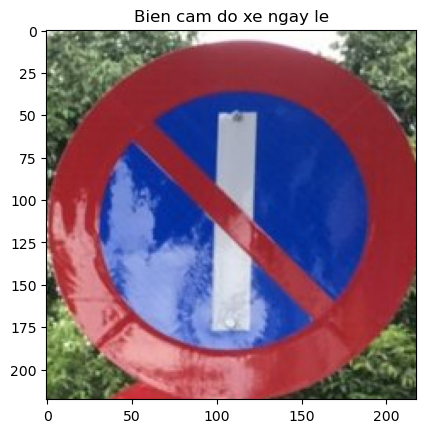

Processed and saved m1.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m10.jpg


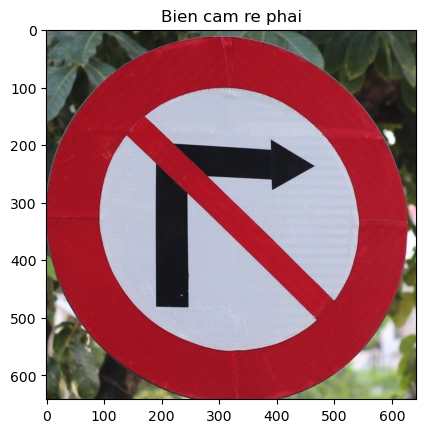

Processed and saved m10.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m11.jpg


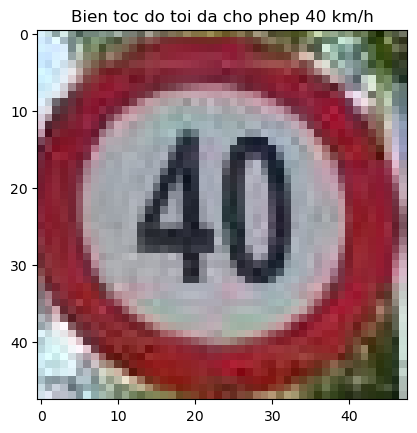

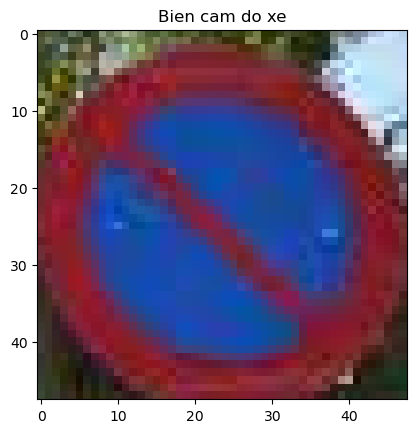

Processed and saved m11.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m12.jpg


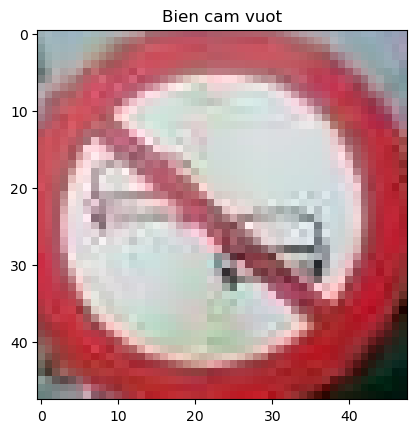

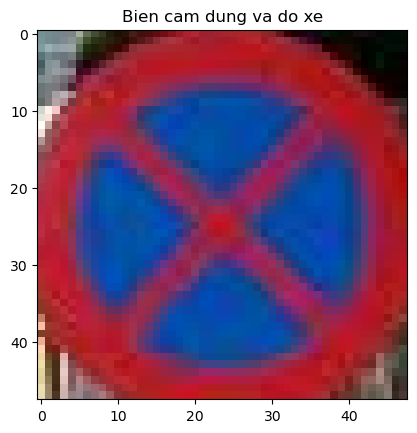

Processed and saved m12.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m13.jpg


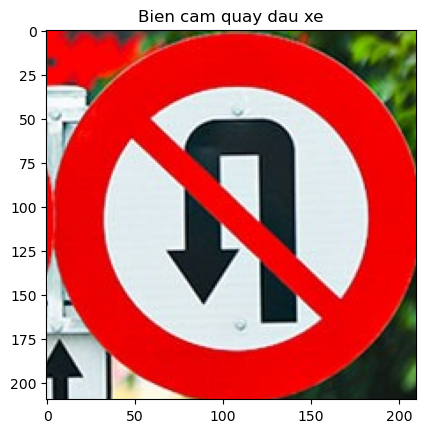

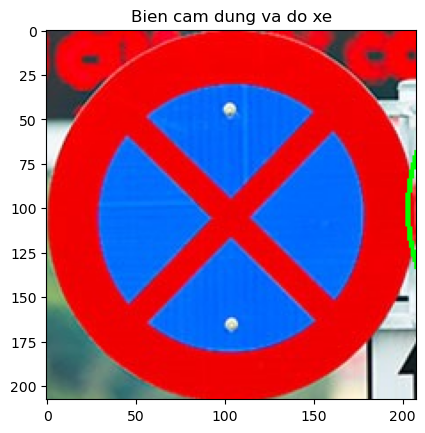

Processed and saved m13.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m14.jpg


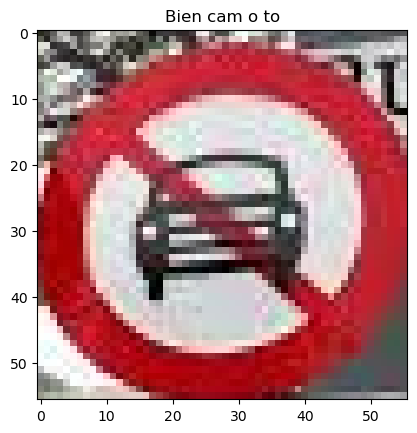

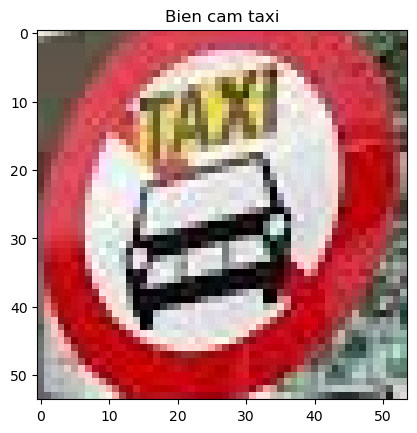

Processed and saved m14.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m15.jpg


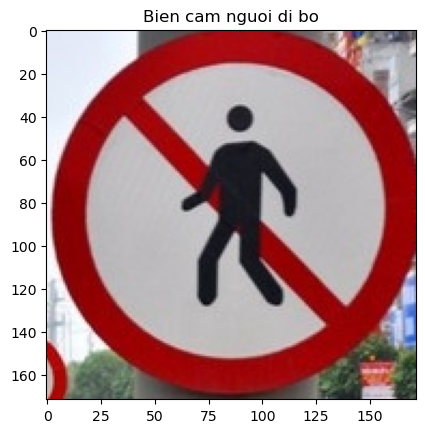

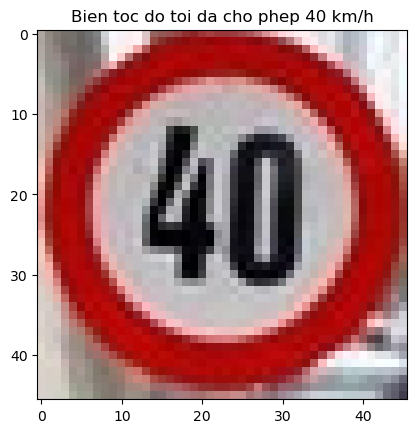

Processed and saved m15.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m2.jpg


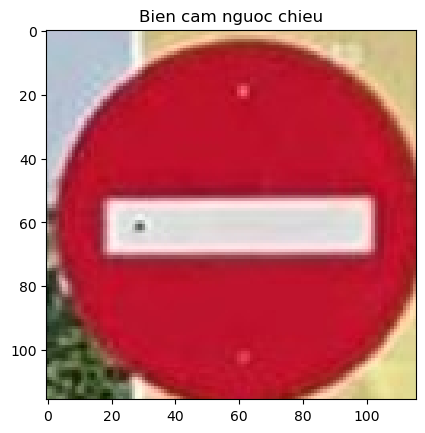

Processed and saved m2.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m3.jpg


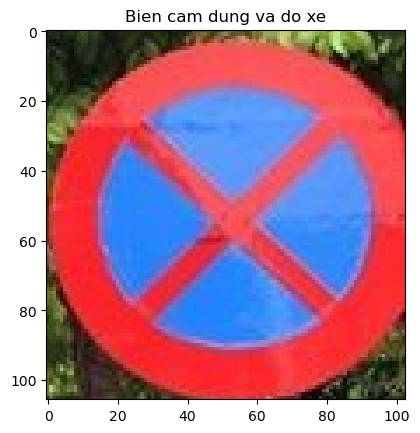

Processed and saved m3.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m4.jpg


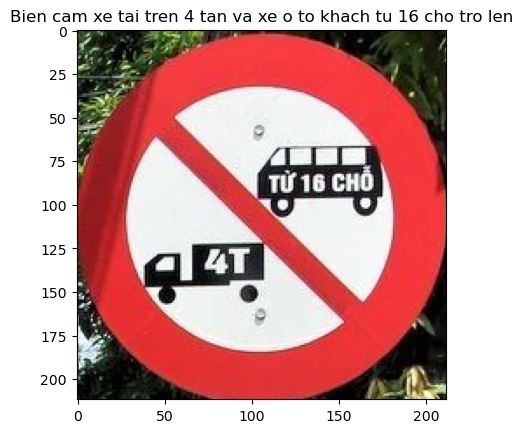

Processed and saved m4.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m5.jpg


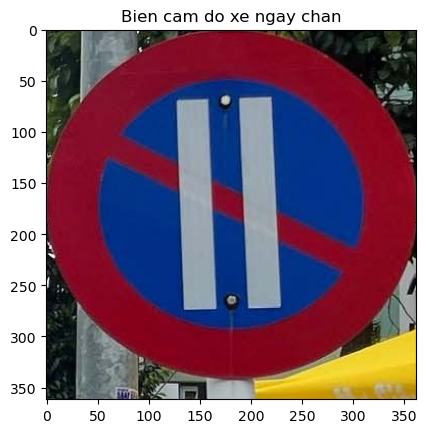

Processed and saved m5.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m6.jpg


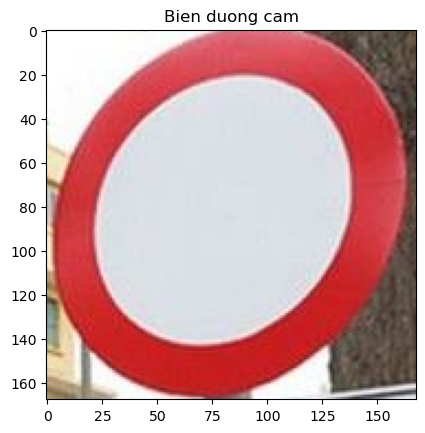

Processed and saved m6.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m7.jpg


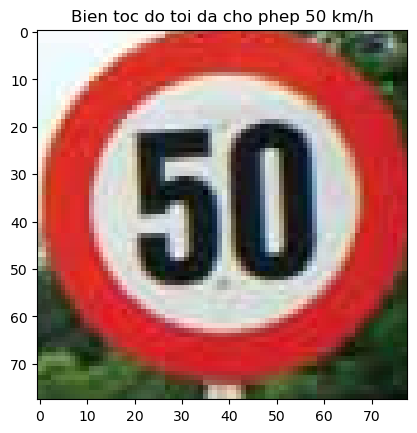

Processed and saved m7.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m8.jpg


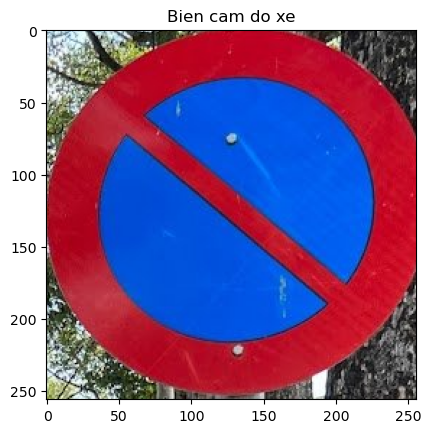

Processed and saved m8.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------
m9.jpg


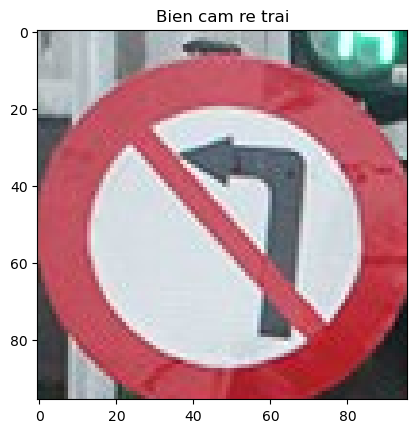

Processed and saved m9.jpg to E:\TDTU_Work\DIP\Final\testoutput\ver8
-------------------------------


In [127]:
# Define paths

input_folder2 = r"E:\TDTU_Work\DIP\Final\data\NewData"
output_folder2 = r"E:\TDTU_Work\DIP\Final\testoutput"
check = "ver8"
# Process images
process_images2(input_folder2, output_folder2, check)